# numpy implementation of simulation

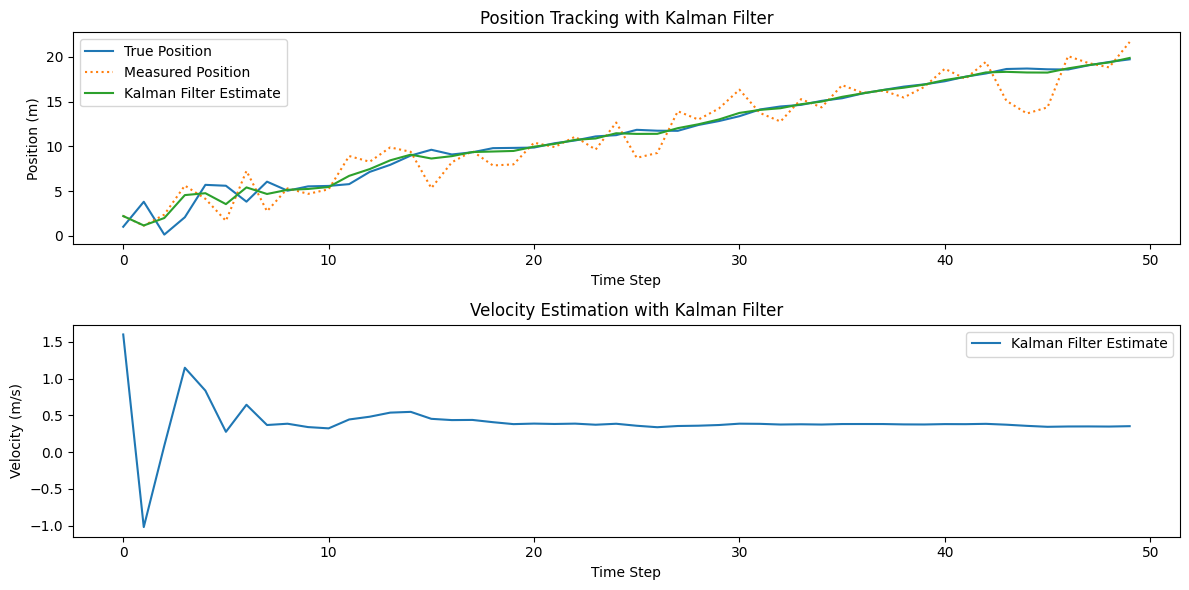

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt


random.seed(42)
# Time step
dt = 1.0  # seconds

# State transition matrix
F = np.array([[1, dt],
              [0,  1]])

# Control input matrix (not used in this example)
B = np.array([[0],
              [0]])

# Observation matrix
H = np.array([[1, 0]])

# Process noise covariance (small, assuming relatively constant velocity)
Q = np.array([[1e-5, 0],
              [0, 1e-5]])

# Measurement noise covariance (reflecting the noise in position measurements)
R = np.array([[4]])  # variance of the measurement noise

# Initial state vector (position=0, velocity=1)
x = np.array([[0],
              [1]])

# Initial covariance matrix (large initial uncertainty)
P = np.array([[1000, 0],
              [0, 1000]])

# Number of time steps
num_steps = 50

# Storage for plotting
true_positions = []
measurements = []
kalman_positions = []
kalman_velocities = []

for i in range(num_steps):
    # True position and velocity (constant velocity motion)
    true_position = x[0, 0] + x[1, 0] * dt
    true_velocity = x[1, 0]

    # Noisy measurement of position
    measurement = true_position + np.random.normal(0, np.sqrt(R[0, 0]))

    # Prediction Step
    x = np.dot(F, x)
    P = np.dot(np.dot(F, P), F.T) + Q

    # Measurement Update (Correction) Step
    y = measurement - np.dot(H, x)  # Measurement residual
    S = np.dot(H, np.dot(P, H.T)) + R  # Residual covariance
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S))  # Kalman gain
    x = x + np.dot(K, y)
    P = np.dot((np.eye(2) - np.dot(K, H)), P)

    # Store results for plotting
    true_positions.append(true_position)
    measurements.append(measurement)
    kalman_positions.append(x[0, 0])
    kalman_velocities.append(x[1, 0])

# Plotting the results
plt.figure(figsize=(12, 6))

# Position plot
plt.subplot(2, 1, 1)
plt.plot(true_positions, label="True Position")
plt.plot(measurements, label="Measured Position", linestyle='dotted')
plt.plot(kalman_positions, label="Kalman Filter Estimate")
plt.xlabel("Time Step")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Position Tracking with Kalman Filter")

# Velocity plot
plt.subplot(2, 1, 2)
plt.plot(kalman_velocities, label="Kalman Filter Estimate")
plt.xlabel("Time Step")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.title("Velocity Estimation with Kalman Filter")

plt.tight_layout()
plt.show()


# implement kalman filter library for simulation

Iteration 1: Residual Mean = [-0.50813182  0.01660631], Residual Std Dev = [1.46279353 0.04722226]
Iteration 2: Residual Mean = [-0.54967555  0.00781897], Residual Std Dev = [1.63986339 0.02194834]
Iteration 2: Covariance Matrix Difference = 0.8048
Iteration 3: Residual Mean = [-0.57280134  0.00391692], Residual Std Dev = [1.76238802 0.01078143]
Iteration 3: Covariance Matrix Difference = 0.4048
Iteration 4: Residual Mean = [-0.58485051  0.00201147], Residual Std Dev = [1.85078755 0.00543869]
Iteration 4: Covariance Matrix Difference = 0.2152
Iteration 5: Residual Mean = [-0.59008227  0.0010416 ], Residual Std Dev = [1.91542551 0.0027769 ]
Iteration 5: Covariance Matrix Difference = 0.1232
Iteration 6: Residual Mean = [-5.91451418e-01  5.39930551e-04], Residual Std Dev = [1.96355032e+00 1.42435102e-03]
Iteration 6: Covariance Matrix Difference = 0.0782
Iteration 7: Residual Mean = [-5.90829573e-01  2.79356633e-04], Residual Std Dev = [2.00030598e+00 7.31241356e-04]
Iteration 7: Covaria

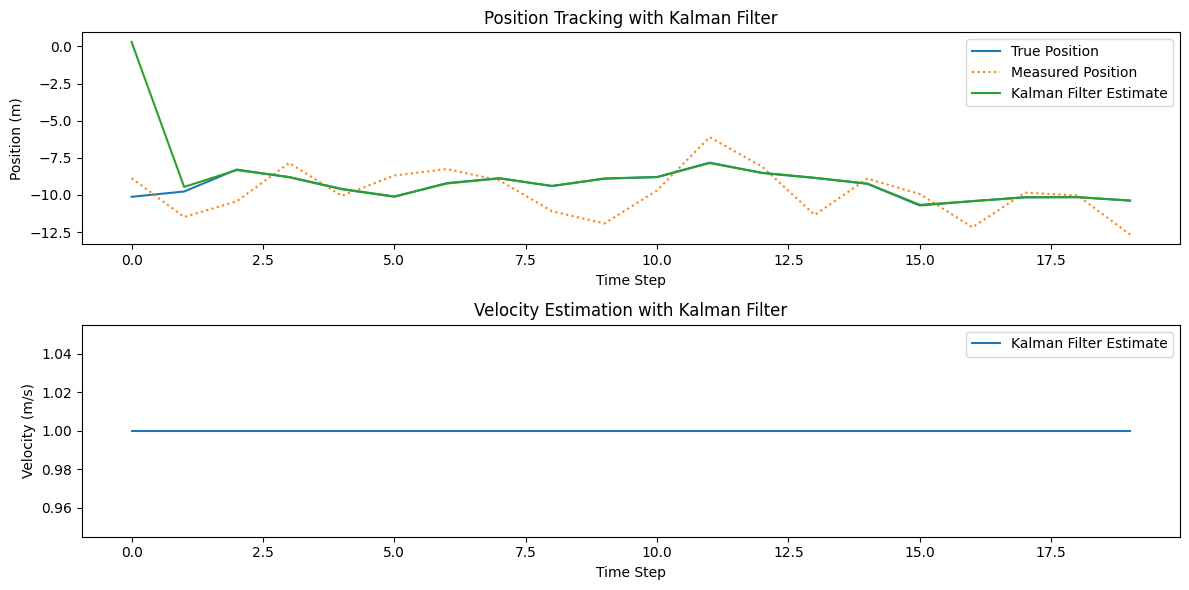

In [14]:
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Generate synthetic data for demonstration
np.random.seed(42)
n_timesteps = 100
true_position = np.cumsum(np.random.normal(0, 1, n_timesteps))
true_velocity = np.ones(n_timesteps)
measurement_noise = np.random.normal(0, 2, n_timesteps)
observed_position = true_position + measurement_noise

# Prepare the training and test data
X_train = np.column_stack([true_position[:80], true_velocity[:80]])
X_test = np.column_stack([true_position[80:], true_velocity[80:]])

# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=np.zeros(X_train.shape[1]),
                  n_dim_obs=X_train.shape[1],
                  n_dim_state=X_train.shape[1])

# Track metrics over iterations
prev_covariance_matrix = None
residual_means = []
residual_stds = []
covariance_diffs = []

true_positions = []
measurements = []
kalman_positions = []
kalman_velocities = []

for i in range(100):
    kf = kf.em(X_train, n_iter=1)
    state_means, state_covariances = kf.filter(X_test)
    
    # Calculate residuals
    residuals = X_test - state_means
    residual_mean = np.mean(residuals, axis=0)
    residual_std = np.std(residuals, axis=0)
    
    residual_means.append(residual_mean)
    residual_stds.append(residual_std)
    
    print(f"Iteration {i+1}: Residual Mean = {residual_mean}, Residual Std Dev = {residual_std}")
    
    # Covariance Matrix Stability
    if prev_covariance_matrix is not None:
        covariance_diff = np.linalg.norm(state_covariances - prev_covariance_matrix)
        covariance_diffs.append(covariance_diff)
        print(f"Iteration {i+1}: Covariance Matrix Difference = {covariance_diff:.4f}")
    
    prev_covariance_matrix = state_covariances

    # For plotting purposes
    true_positions.append(X_test[:, 0])
    measurements.append(observed_position[80:])  # Assume observed_position was your test data
    kalman_positions.append(state_means[:, 0])
    kalman_velocities.append(state_means[:, 1])

# Convert lists to arrays for plotting
true_positions = np.array(true_positions)
measurements = np.array(measurements)
kalman_positions = np.array(kalman_positions)
kalman_velocities = np.array(kalman_velocities)

# Plotting the results
plt.figure(figsize=(12, 6))

# Position plot
plt.subplot(2, 1, 1)
plt.plot(true_positions[-1], label="True Position")
plt.plot(measurements[-1], label="Measured Position", linestyle='dotted')
plt.plot(kalman_positions[-1], label="Kalman Filter Estimate")
plt.xlabel("Time Step")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Position Tracking with Kalman Filter")

# Velocity plot
plt.subplot(2, 1, 2)
plt.plot(kalman_velocities[-1], label="Kalman Filter Estimate")
plt.xlabel("Time Step")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.title("Velocity Estimation with Kalman Filter")

plt.tight_layout()
plt.show()
